1. Download Dataset

In [1]:
import os

In [2]:
# 1. Setup Kaggle credentials directly in code
# REPLACE these values with your actual Kaggle username and key
os.environ['KAGGLE_USERNAME'] = "clark-projects"
os.environ['KAGGLE_KEY'] = "KGAT_a62b4d2750933dafbf0e4b558bd05cb0"

In [3]:
# 2. Download the dataset using the Kaggle API
# The dataset URL is: https://www.kaggle.com/omkargurav/face-mask-dataset
print("Downloading dataset...")
!kaggle datasets download -d omkargurav/face-mask-dataset

# 3. Unzip the data
print("Unzipping dataset...")
!unzip -q face-mask-dataset.zip -d face_mask_data

# 4. Define the path
DATASET_DIR = '/content/face_mask_data/data'
print(f"Success! Dataset is ready at: {DATASET_DIR}")

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 51% 83.0M/163M [00:00<00:00, 864MB/s]
100% 163M/163M [00:00<00:00, 709MB/s] 
Unzipping dataset...
Success! Dataset is ready at: /content/face_mask_data/data


2. Imports & Hyperparameters

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Hyperparameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Path from previous step
DATASET_DIR = '/content/face_mask_data/data'

3. Data Loading & Augmentation

In [5]:
# Data Augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Random rotation
    zoom_range=0.15,         # Random zoom
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.15,        # Shear
    horizontal_flip=True,    # Flip
    fill_mode="nearest",
    validation_split=0.2     # 20% validation split
)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

# Load Validation Data
validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


4. Model Building

In [6]:
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Classifier Head
    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(512, activation='relu'),

    # Output Layer
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

# Show the summary as required
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

5. Training

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 90/188 ━━━━━━━━━━━━━━━━━━━━ 22s 232ms/step - accuracy: 0.6468 - loss: 0.7639

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 303ms/step - accuracy: 0.7074 - loss: 0.6303 - val_accuracy: 0.8604 - val_loss: 0.3673
Epoch 2/20
  1/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7500 - loss: 0.6038

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7500 - loss: 0.6038 - val_accuracy: 0.8537 - val_loss: 0.3486
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 272ms/step - accuracy: 0.8290 - loss: 0.3914 - val_accuracy: 0.8797 - val_loss: 0.2958
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9062 - loss: 0.3678 - val_accuracy: 0.8883 - val_loss: 0.2854
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 266ms/step - accuracy: 0.8575 - loss: 0.3374 - val_accuracy: 0.8949 - val_loss: 0.2814
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9375 - loss: 0.3222 - val_accuracy: 0.9062 - val_loss: 0.2754
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.8723 - loss: 0.3164 - val_accuracy: 0.8870 - val_loss: 0.2768
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8750 - loss: 0.2866 - val_accuracy: 0.9089 - val_loss: 0.2518
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 50s 268ms/step - accuracy: 0.8900 - loss: 0.2722 - val_accurac

6. Visualization

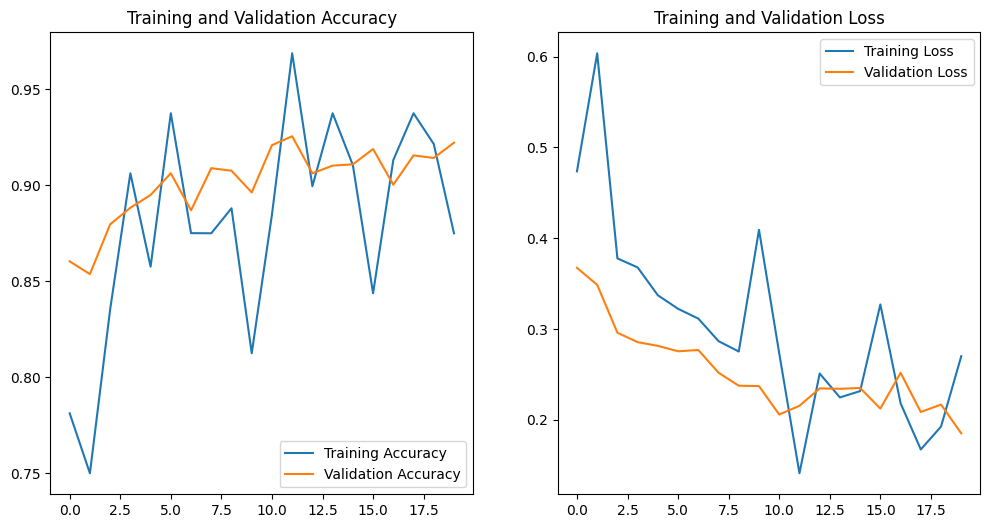

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

7. Summary

In [9]:
# Get the final epoch's results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("------ FINAL RESULTS ------")
print(f"Final Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print("---------------------------")
print(f"Final Training Loss:       {final_train_loss:.4f}")
print(f"Final Validation Loss:     {final_val_loss:.4f}")

------ FINAL RESULTS ------
Final Training Accuracy:   87.50%
Final Validation Accuracy: 92.22%
---------------------------
Final Training Loss:       0.2700
Final Validation Loss:     0.1849


# Model Results and Summary

## Results
* **Final Training Accuracy:** [87.50%]
* **Final Validation Accuracy:** [92.22%]

## Approach
I implemented a Convolutional Neural Network (CNN) from scratch using the Kaggle Face Mask dataset.

## Key Improvements
1.  **Data Augmentation:** I used `ImageDataGenerator` to apply random rotations, zooms, and shifts. This forces the model to learn robust features of the mask itself rather than memorizing the specific background or angle of the training images.
2.  **Dropout:** I integrated a `Dropout` layer (50%) before the dense layers. This regularization technique significantly reduces overfitting, which is a common challenge when training custom models on smaller datasets.

## Future Recommendations
To further improve performance, I would consider:
* **Learning Rate Scheduling:** To dynamically adjust the learning rate during training.
* **L2 Regularization:** To penalize large weights and further prevent overfitting.